# Imports

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('../Data/MarineMicroplastics.csv')

In [3]:
df.head(2)

,FID,Date,Latitude,Longitude,Oceans,Regions,SubRegions,Measurement,Unit,Density Range,...,Accession Number,Accession Link,GlobalID,CreationDate,Creator,EditDate,Editor,Long Reference,x,y
0,40055,4/3/2011 12:00:00 AM,-30.2413,-97.0948,Pacific Ocean,NaN,NaN,0.390376,pieces/m3,0.005-1,...,275968,https://www.ncei.noaa.gov/access/metadata/land...,4078602b-702b-4514-b625-4b08fb50d16c,3/9/2023 9:05:33 PM,ncei_cds_noaa,3/9/2023 9:05:33 PM,ncei_cds_noaa,"Eriksen, M., L.C.M. Lebreton, H.S. Carson, M. ...",-1.080854e+07,-3.534605e+06
1,39794,11/27/2010 12:00:00 AM,-33.5729,-13.7057,Atlantic Ocean,NaN,NaN,0.976803,pieces/m3,0.005-1,...,275968,https://www.ncei.noaa.gov/access/metadata/land...,fff505a7-d6da-435d-9b6e-8263bf448e78,3/9/2023 9:05:33 PM,ncei_cds_noaa,3/9/2023 9:05:33 PM,ncei_cds_noaa,"Eriksen, M., L.C.M. Lebreton, H.S. Carson, M. ...",-1.525712e+06,-3.971596e+06


# Preprocessing data

In [4]:
df.columns

Index(['FID', 'Date', 'Latitude', 'Longitude', 'Oceans', 'Regions',
       'SubRegions', 'Measurement', 'Unit', 'Density Range', 'Density Class',
       'Sampling Method', 'Short Reference', 'DOI', 'Organization', 'Keywords',
       'Accession Number', 'Accession Link', 'GlobalID', 'CreationDate',
       'Creator', 'EditDate', 'Editor', 'Long Reference', 'x', 'y'],
      dtype='object')

In [5]:
df.dtypes

FID                   int64
Date                 object
Latitude            float64
Longitude           float64
Oceans               object
Regions              object
SubRegions           object
Measurement         float64
Unit                 object
Density Range        object
Density Class        object
Sampling Method      object
Short Reference      object
DOI                  object
Organization         object
Keywords             object
Accession Number      int64
Accession Link       object
GlobalID             object
CreationDate         object
Creator              object
EditDate             object
Editor               object
Long Reference       object
x                   float64
y                   float64
dtype: object

In [6]:
df.head(1)

,FID,Date,Latitude,Longitude,Oceans,Regions,SubRegions,Measurement,Unit,Density Range,...,Accession Number,Accession Link,GlobalID,CreationDate,Creator,EditDate,Editor,Long Reference,x,y
0,40055,4/3/2011 12:00:00 AM,-30.2413,-97.0948,Pacific Ocean,NaN,NaN,0.390376,pieces/m3,0.005-1,...,275968,https://www.ncei.noaa.gov/access/metadata/land...,4078602b-702b-4514-b625-4b08fb50d16c,3/9/2023 9:05:33 PM,ncei_cds_noaa,3/9/2023 9:05:33 PM,ncei_cds_noaa,"Eriksen, M., L.C.M. Lebreton, H.S. Carson, M. ...",-1.080854e+07,-3.534605e+06


In [7]:
# Set index as a time series
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.head(1)

,FID,Latitude,Longitude,Oceans,Regions,SubRegions,Measurement,Unit,Density Range,Density Class,...,Accession Number,Accession Link,GlobalID,CreationDate,Creator,EditDate,Editor,Long Reference,x,y
Date,,,,,,,,,,,,,,,,,,,,,
1972-04-20,40541,39.0,-141.017,Pacific Ocean,NaN,NaN,0.017,pieces/m3,0.005-1,Medium,...,253448,https://www.ncei.noaa.gov/access/metadata/land...,cd81c3c8-9fd5-4743-8aa7-b73bdbdd92e0,3/9/2023 9:05:33 PM,ncei_cds_noaa,3/9/2023 9:05:33 PM,ncei_cds_noaa,"Goldstein, M.C., A.J. Titmus, M. Ford. 2013. S...",-1.569794e+07,4.721672e+06


# Train test split

In [8]:
df.columns

Index(['FID', 'Latitude', 'Longitude', 'Oceans', 'Regions', 'SubRegions',
       'Measurement', 'Unit', 'Density Range', 'Density Class',
       'Sampling Method', 'Short Reference', 'DOI', 'Organization', 'Keywords',
       'Accession Number', 'Accession Link', 'GlobalID', 'CreationDate',
       'Creator', 'EditDate', 'Editor', 'Long Reference', 'x', 'y'],
      dtype='object')

The columns were using are latitude and longitude because that more or less describes the ocean, region, and subregion. We noticed a significant difference in sample concentrations based on the sampling method, so theoretically that should be able to predict microplastic concentrations.

In [9]:
df[df['Sampling Method'] == 'AVANI net'].head(2)

,FID,Latitude,Longitude,Oceans,Regions,SubRegions,Measurement,Unit,Density Range,Density Class,...,Accession Number,Accession Link,GlobalID,CreationDate,Creator,EditDate,Editor,Long Reference,x,y
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-27,39634,5.7092,83.7172,Indian Ocean,NaN,NaN,0.012781,pieces/m3,0.005-1,Medium,...,275967,https://www.ncei.noaa.gov/access/metadata/land...,afb2ca57-6d4f-4a6f-9e33-1ebdfe61be53,3/9/2023 9:05:33 PM,ncei_cds_noaa,3/9/2023 9:05:33 PM,ncei_cds_noaa,"Eriksen, M., M. Liboiron, T. Kiessling, L. Cha...",9.319356e+06,636599.5758
2013-05-27,39632,5.6413,83.1797,Indian Ocean,NaN,NaN,0.012001,pieces/m3,0.005-1,Medium,...,275967,https://www.ncei.noaa.gov/access/metadata/land...,aa4bb960-1780-4a70-a3a6-5a02b6995c4d,3/9/2023 9:05:33 PM,ncei_cds_noaa,3/9/2023 9:05:33 PM,ncei_cds_noaa,"Eriksen, M., M. Liboiron, T. Kiessling, L. Cha...",9.259522e+06,629003.7501


In [28]:
#function to take the df frame and sampling method to train test split
def train_test(df, sample_method):
    df = df[df['Sampling Method'] == sample_method]
    X = df[['Latitude','Longitude', 'Oceans']]
    y= df['Measurement'].values
    #X = X.dropna().copy()
    X = pd.get_dummies(data = X, columns = ['Oceans'], drop_first = True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)
    return X_train, X_test, y_train, y_test

## Scaling data


Normally we need to scale, but here we have mostly dummy variables except for our latitude and longitude which shouldn't be scaled.


# Time series generator

This portion referred to the  [RNN lesson](https://git.generalassemb.ly/dsir-0320/8.05-lesson-rnn/blob/main/starter_code_Hank_dsir_0320.ipynb)

In [48]:
def time_seq(X_test, y_test):
    train_sequences = TimeseriesGenerator(X_train, y_train, length = 1, batch_size = 32)
    test_sequences = TimeseriesGenerator(X_test, y_test, length = 1, batch_size = 32)
    batch_x, batch_y = train_sequences[0]
    print(f' x batch is {batch_x.shape} \n y batch is  {batch_y.shape}')
    return train_sequences, test_sequences
    

# Modeling

In [24]:
sampling_methods = list(set(df['Sampling Method']))

In [13]:
sampling_methods

['Neuston net',
 'Grab sample',
 'Surface water intake',
 'Manta net',
 'Stainless steel bucket',
 'Intake seawater',
 'AVANI net',
 'Plankton net',
 'Aluminum bucket']

## Neuston Net

In [135]:
X_train, X_test, y_train, y_test = train_test(df,sampling_methods[0])

In [136]:
time_seq(X_test, y_test);

 x batch is (32, 1, 6) 
 y batch is  (32,)


In [137]:
X_train.shape

(7281, 6)

In [138]:
baseline_preds= np.full((1, len(y_test)), y_train.mean())[0]
print(f'Baseline Model MSE: {mean_squared_error(y_test, baseline_preds)} ')

Baseline Model MSE: 2.5658535938151554 


In [51]:
input_shape = train_sequences[0][0][0].shape

In [106]:
model = Sequential()
#model.add(Conv1D(filters=32,kernel_size=3, activation='relu'))
model.add(GRU(64, input_shape=input_shape, return_sequences = True,kernel_regularizer=l2(0.015))) 
model.add(GRU(16, return_sequences = False)) 
model.add(Dense(8, activation = 'relu'))
model.add(Dropout(0.005))
model.add(Dense(8, activation = 'relu'))
# output layer
model.add(Dense(1, activation = None))

In [107]:
#Used early stopping because model stopped learning pretty early https://keras.io/api/callbacks/early_stopping/
model.compile(loss = 'mse',
              optimizer = Adam(learning_rate = 0.35),
              metrics = ['mse'])

history = model.fit(train_sequences,
                    validation_data = test_sequences,
                    epochs = 10,
                    callbacks=EarlyStopping(patience=3))

Epoch 1/10
228/228 [==============================] - 7s 16ms/step - loss: 1.7014 - mse: 0.3761 - val_loss: 6.1669 - val_mse: 2.5913
Epoch 2/10
228/228 [==============================] - 3s 12ms/step - loss: 0.5910 - mse: 0.0313 - val_loss: 2.6791 - val_mse: 2.5973
Epoch 3/10
228/228 [==============================] - 3s 12ms/step - loss: 0.0710 - mse: 0.0312 - val_loss: 2.5741 - val_mse: 2.5558
Epoch 4/10
228/228 [==============================] - 3s 14ms/step - loss: 0.0432 - mse: 0.0322 - val_loss: 2.6123 - val_mse: 2.6064
Epoch 5/10
228/228 [==============================] - 3s 15ms/step - loss: 0.0353 - mse: 0.0320 - val_loss: 2.5296 - val_mse: 2.5280
Epoch 6/10
228/228 [==============================] - 3s 13ms/step - loss: 0.0340 - mse: 0.0322 - val_loss: 2.5939 - val_mse: 2.5908
Epoch 7/10
228/228 [==============================] - 4s 16ms/step - loss: 0.0344 - mse: 0.0327 - val_loss: 2.6129 - val_mse: 2.6112
Epoch 8/10
228/228 [==============================] - 3s 15ms/step - 

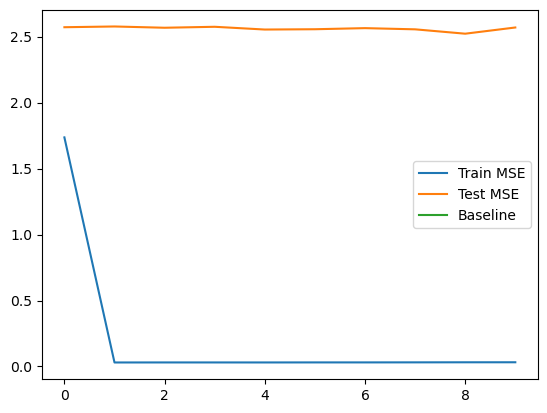

In [64]:
#plotting MSE

plt.plot(history.history['mse'], label = 'Train MSE')
plt.plot(history.history['val_mse'], label = 'Test MSE')

plt.legend();

In [90]:
df.head(1)

,FID,Latitude,Longitude,Oceans,Regions,SubRegions,Measurement,Unit,Density Range,Density Class,...,Accession Number,Accession Link,GlobalID,CreationDate,Creator,EditDate,Editor,Long Reference,x,y
Date,,,,,,,,,,,,,,,,,,,,,
1972-04-20,40541,39.0,-141.017,Pacific Ocean,NaN,NaN,0.017,pieces/m3,0.005-1,Medium,...,253448,https://www.ncei.noaa.gov/access/metadata/land...,cd81c3c8-9fd5-4743-8aa7-b73bdbdd92e0,3/9/2023 9:05:33 PM,ncei_cds_noaa,3/9/2023 9:05:33 PM,ncei_cds_noaa,"Goldstein, M.C., A.J. Titmus, M. Ford. 2013. S...",-1.569794e+07,4.721672e+06


In [95]:
df[['Density Range']][df['Sampling Method'] == sampling_methods[0]].value_counts()

Density Range
0-0.0005         4076
0.005-1          3932
0.0005-0.005     1444
1-10              250
>=10                6
dtype: int64

In [87]:
model.evaluate(train_sequences)

228/228 [==============================] - 2s 7ms/step - loss: 0.0325 - mse: 0.0300


[0.032528698444366455, 0.030018918216228485]

In [86]:
model.evaluate(test_sequences)

76/76 [==============================] - 1s 7ms/step - loss: 2.5721 - mse: 2.5696


[2.5720760822296143, 2.5695667266845703]

For our training MSE our errors seem to be within a common range of values; on the other hand, our test MSE appears to have errors that fall into a more uncommon upper range. 

In [142]:
X_test_preds= X_test.iloc[:, 0:].values.reshape(-1, 1,6)

In [144]:
preds = model.predict(X_test_preds)

76/76 [==============================] - 0s 4ms/step


In [145]:
preds

array([[0.06167768],
       [0.06167768],
       [0.06167768],
       ...,
       [0.06167768],
       [0.06167768],
       [0.06167768]], dtype=float32)